In [ ]:
!pip install galpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
[6.73, 23.788674083688075, 18.047252897037243, 0.6123843042729903]
0.094


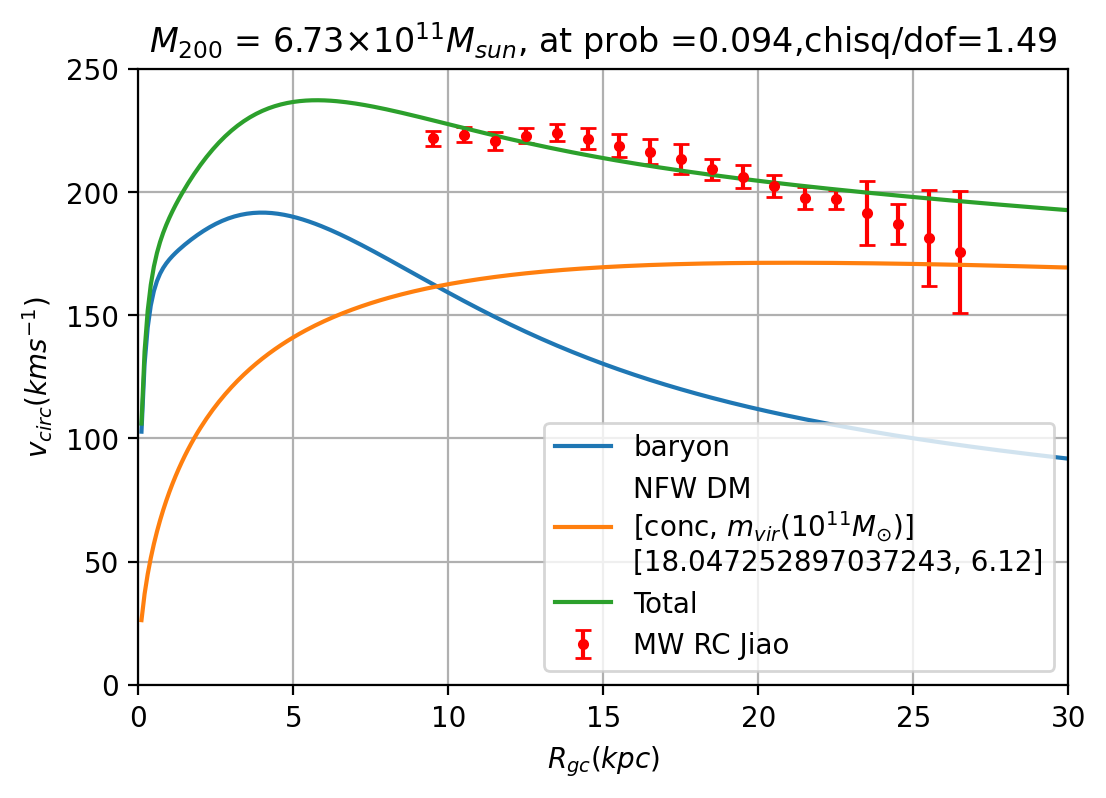

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 22 20:44:56 2025

@author: akib
"""

import numpy as np
import astropy.units as u
from astropy.io import ascii
from galpy.potential import AnySphericalPotential, NFWPotential
from galpy.util import conversion
import matplotlib.pyplot as plt

path_to_files = '/content/drive/MyDrive/astworkshop/'
rc_mw_jiao23_file = path_to_files + 'rc_mw_jiao23.txt'
v_bary_J23_file = path_to_files + 'v_bary_J23.npy'
v_bary_b2_plot_file = path_to_files + 'v_bary_b2_plot.npy'


# Assuming ro and vo are defined globally or earlier in the script
ro = 8.178 * u.kpc
vo = 247.3 * u.km / u.s
massol = conversion.mass_in_msol(vo, ro)
mass_bary = 0.61  # x10^11 M_sun

# Read data using the paths
rc_J23 = ascii.read(rc_mw_jiao23_file)
v_bary = np.load(v_bary_J23_file, allow_pickle=True)
r, v, ev = np.array([rc_J23['R'], rc_J23['Vc'], rc_J23['eVc']])

# Load additional numpy array
v_bary_plot = np.load(v_bary_b2_plot_file, allow_pickle=True)
r_plot = np.linspace(0.1, 30, 300)

# Plotting the data
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
ax.errorbar(r, v, yerr=ev, fmt='r.', label='MW RC Jiao', capsize=3)
ax.plot(r_plot, v_bary_plot, label='baryon')

ax.set(xlim=(0, 30), ylim=(0, 250), xlabel=r'$R_{gc}(kpc)$', ylabel=r'$v_{circ}(kms^{-1})$',
       title='MW RC from Jiao et al. 2023, Baryon from de Salas et al. 2019')
ax.grid()
ax.legend(loc='lower right')
plt.show()


#------------------------------------------------------------------------------------------------------------------

#%%
def calc_vals_nfw(nfw_param):
    [c,mvirial]=nfw_param
    nfw=NFWPotential(conc=c, mvir=mvirial, wrtcrit=True,ro=ro,vo=vo)
    m_tot = np.round(mass_bary + mvirial*10,2)

    v_nfw = np.array([nfw.vcirc(rad * u.kpc) for rad in r])
    v_circ = np.sqrt(v_bary**2+ v_nfw**2)

    chisq= np.sum((v_circ-v)**2/ev**2)

    return [m_tot, chisq]

def new_nfw_param(param,size):
    newpar=[]
    for i in range(len(param)):
        newpar.append(np.random.uniform(param[i] - param[i]*size, param[i] + param[i]*size))
    return newpar



#%% ----------------------------------------------------------------------------------------------------------------
#best NFW fit
i_max = 10000 #maximum iteration
step_size = 0.15
min_step = 0.01


cur_par = [17, 1]
[cur_mass, cur_chisq] = calc_vals_nfw(cur_par)
accepted_par = [[cur_mass, cur_chisq, *cur_par]] #array that stores parameters with low error
for i in range(i_max):
    if i%(round(i_max/10))==0: print(round(100*i/i_max), '% done')

    T = 1 - i/i_max
    step = min_step+(step_size-min_step)*T
    next_par = new_nfw_param(cur_par,step)
    [next_mass, next_chisq] = calc_vals_nfw(next_par)

    if np.exp(-(next_chisq - cur_chisq)/T) > np.random.uniform(0, 1):
                cur_par = next_par
                cur_mass = next_mass
                cur_chisq = next_chisq

                accepted_par.append([cur_mass, cur_chisq, *cur_par])
print(accepted_par[np.argmin(np.transpose(accepted_par)[1])])







#%% ---------------------------------------------------------------------------------------


param_plot_best = accepted_par[np.argmin(np.transpose(accepted_par)[1])][2:]
[c,mvirial]=param_plot_best
nfw=NFWPotential(conc=c, mvir=mvirial, wrtcrit=True,ro=ro,vo=vo)
v_nfw = np.array([nfw.vcirc(rad * u.kpc) for rad in r])
v_circ = np.sqrt(v_bary**2+ v_nfw**2)
chisq= np.sum((v_circ-v)**2/ev**2)


prob = np.round(gammaincc((len(r)-len(param_plot_best))/2,chisq/2),3)
print(prob)
mass_DM =np.round(param_plot_best[1]*10,2)

v_nfw_plot = np.array([nfw.vcirc(rad * u.kpc) for rad in r_plot])
v_circ = np.sqrt(v_bary_plot**2+ v_nfw_plot**2)


fig, ax = plt.subplots(figsize=(6,4),dpi=200)
ax.errorbar(r,v, yerr = ev, fmt='r.', label='MW RC Jiao', capsize=3)
ax.plot(r_plot, v_bary_plot, label='baryon')
ax.plot(r_plot, v_nfw_plot, label='NFW DM'+'\n'+
        r'[conc, $m_{vir}(10^{11} M_{\odot})$]'+'\n'+str([param_plot_best[0],np.round(10*param_plot_best[1],2)]))
ax.plot(r_plot, v_circ, label='Total')
ax.set(xlim=(0,30), ylim=(0,250), xlabel=r'$R_{gc}(kpc)$', ylabel=r'$v_{circ}(kms^{-1})$',
       title =r'$M_{200}$ = '+str(round(mass_bary+mass_DM,2))+r'$\times10^{11}M_{sun}$'+
      ', at prob ='+str(prob) +',chisq/dof=' +str(round(chisq/(len(r)-len(param_plot_best)),2)))

ax.grid()
ax.legend(loc='lower right')
plt.show()



#%%% ------------------------------------------------------------------------------------------------------------------
#high mass NFW fit
i_max = 10000 #maximum iteration
step_size = 0.15
min_step = 0.01

cur_par = param_plot_best

#Do
#the
#rest
#for
#probability gammaincc((len(r)-len(cur_par))/2,next_chisq/2)>=0.01

#%%
#plot

#%% ----------------------------------------------------


def eval_ave_dens(Pot, r):
    # Use Pot.mass() as a function call
    dens = Pot.mass(R=r*u.kpc, z=None) / ((4/3) * np.pi * (r*1000)**3)
    return dens

def R_200(Pot):
    rad = np.linspace(50, 300, 26)
    # Use eval_ave_dens() as a function call
    diff = abs(np.round(np.array([eval_ave_dens(Pot, r) for r in rad]) * 10**5 - 2.68, 2))
    rmin = rad[np.argmin(diff)]
    if min(diff) == 0:
        r_200 = rmin
    else:
        rad_n = np.round(np.linspace(rmin - 10, rmin + 10, 21), 2)
        # Use eval_ave_dens() as a function call
        diff_n = abs(np.round(np.array([eval_ave_dens(Pot, r) for r in rad_n]) * 10**5 - 2.68, 2))
        rmin = rad_n[np.argmin(diff_n)]
        if min(diff) == 0:
            r_200 = rmin
        else:
            rad_n = np.round(np.linspace(rmin - 1, rmin + 1, 21), 2)
            # Use eval_ave_dens() as a function call
            diff_n = abs(np.round(np.array([eval_ave_dens(Pot, r) for r in rad_n]) * 10**5 - 2.68, 2))
            r_200 = rad_n[np.argmin(diff_n)]
    return r_200

def calc_vals_ein(ein_param):
    [mdm,h,n]=ein_param

    h = h/ro.value
    rho0=np.array((mdm*10**11)/massol/(np.pi*4.*h**3))
    eina=AnySphericalPotential(dens=lambda r:np.exp(-(r/h)**(1/n)),amp=rho0,ro=ro,vo=vo)

    v_eina = np.array([eina.vcirc(rad * u.kpc) for rad in r])
    v_circ = np.sqrt(v_bary**2+ v_eina**2)

    chisq = np.sum((v_circ-v)**2/ev**2)
    mass = mass_bary+np.round(eina.mass(R_200(eina)*u.kpc,z=None)/10**11,2)

    return [mass,chisq]

def new_ein_param(param,size):
    newpar=[]
    for i in range(len(param)):
        if i==0:
            lp = np.log10(param[i])
            nlp = np.random.uniform(lp - lp*size, lp + lp*size)
            newpar.append(10**nlp)
        else:
            newpar.append(np.random.uniform(param[i] - param[i]*size, param[i] + param[i]*size))
    return newpar
#%%
#best ein fit ------------------------------------------------------------------------------
i_max = 5000 #maximum iteration
step_size = 0.25
min_step = 0.01


cur_par = [3, 10, 1]


[cur_mass, cur_chisq] = calc_vals_ein(cur_par)
accepted_par = [[cur_mass, cur_chisq, *cur_par]] #array that stores parameters with low error
for i in range(i_max):
    if i%(round(i_max/10))==0: print(round(100*i/i_max), '% done')

    T = 1 - i/i_max
    step = min_step+(step_size-min_step)*T
    next_par = new_ein_param(cur_par,step)
    [next_mass, next_chisq] = calc_vals_ein(next_par)

    if np.exp(-(next_chisq - cur_chisq)/T) > np.random.uniform(0, 1):
                cur_par = next_par
                cur_mass = next_mass
                cur_chisq = next_chisq

                accepted_par.append([cur_mass, cur_chisq, *cur_par])
print(accepted_par[np.argmin(np.transpose(accepted_par)[1])])


#%% --------------------------------------------------------------------------------


param_plot_best = param_plot_best = accepted_par[np.argmin(np.transpose(accepted_par)[1])][2:]
# param_plot_best should contain the best-fit parameters for the Einasto profile

[mdm,h,n]=param_plot_best
r_n2 = h*(2*n)**n
h = h/ro.value
rho0=np.array((mdm*10**11)/massol/(np.pi*4.*h**3))
eina=AnySphericalPotential(dens=lambda r:np.exp(-(r/h)**(1/n)),amp=rho0,ro=ro,vo=vo)

v_eina = np.array([eina.vcirc(rad * u.kpc) for rad in r])
v_circ = np.sqrt(v_bary**2+ v_eina**2)

chisq= np.sum((v_circ-v)**2/ev**2)
prob = np.round(gammaincc((len(r)-len(param_plot_best))/2,chisq/2),3)
print(prob)
mass_DM = np.round(eina.mass(R_200(eina)*u.kpc,z=None)/10**11,2)

v_eina_plot = np.array([eina.vcirc(rad * u.kpc) for rad in r_plot])
v_circ = np.sqrt(v_bary_plot**2+ v_eina_plot**2)


fig, ax = plt.subplots(figsize=(6,4),dpi=200)
ax.errorbar(r,v, yerr = ev, fmt='r.', label='MW RC Jiao', capsize=3)
ax.plot(r_plot, v_bary_plot, label='baryon')
ax.plot(r_plot, v_eina_plot, label='Einasto DM'+'\n'+ '[mdm h n]'+'\n'
        +str(np.round(param_plot_best,3)))
ax.plot(r_plot, v_circ, label='Total')
ax.set(xlim=(0,30), ylim=(0,250), xlabel=r'$R_{gc}(kpc)$', ylabel=r'$v_{circ}(kms^{-1})$',
       title =r'$M_{200}$ = '+str(round(mass_bary+mass_DM,2))+r'$\times10^{11}M_{sun}$'+
      ', at prob ='+str(prob) +',chisq/dof=' +str(round(chisq/(len(r)-len(param_plot_best)),2)))

ax.grid()
ax.legend(loc='lower right')
plt.show()
#%%
#Do
#Highest
#Mass
#for einasto
#if probability: gammaincc((len(r)-len(cur_par))/2,next_chisq/2)>=0.1:

#%%
#and
#do
#the
#plot
